# Transfer Learning ResNet 50 for Lymphoma Sub-Typing
> Corey Chivers, PhD

This notebook is a toy example illustrating the use of pytorch to implement transfer learning from a pre-trained computer vision deep learning model to an imaging pathology task. 

The purpose is to demonstrate a very basic application of the toolset and concepts.

In [1]:
%matplotlib inline

In [2]:
import torch
from PIL import Image
from torchvision import transforms
from torch import nn
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Prep

The dataset is from [http://andrewjanowczyk.com/use-case-7-lymphoma-sub-type-classification/]

> The NIA curated this dataset to address the need of identifying three sub-types of lymphoma: Chronic Lymphocytic Leukemia (CLL), Follicular Lymphoma (FL), and Mantle Cell Lymphoma (MCL). Currently, class-specific probes are used in order to reliably distinguish the sub-types, but these come with additional cost and equipment overheads. Expert pathologists specializing in these types of lymphomas, on the other hand, have shown promise in being able to differentiate these sub-types on H&E, indicating that there is the potential for a DP approach to be employed. A successful approach would allow for more consistent and less demanding diagnosis of this disease. This dataset was created to mirror real-world situations and as such contains samples prepared by different pathologists at different sites. They have additionally selected samples which contain a larger degree of staining variation than one would normally expect.

The data is organized into three folders containing examples of each of the three classes. First create a list containing image file path and matching label tuples. We'll use this to build a custom dataset and dataset loader using pytorch utilities.

In [3]:
img_labels = []
label_dict = {0: 'CLL',
              1: 'FL',
              2: 'MCL'}
for label_i, label_path in label_dict.items():
    fnames = os.listdir(os.path.join('lymphoma',label_path))
    fnames = [f for f in fnames if f.endswith('.tif')]
    img_labels.extend([(os.path.join('lymphoma',label_path,fname),label_i) for fname in fnames])
np.random.shuffle(img_labels)

prop_train = 0.7
n_train = int(len(img_labels) * prop_train)
train_pairs, test_pairs = img_labels[:n_train], img_labels[n_train:]        

In [4]:
train_pairs[:10]

[('lymphoma/MCL/sj-05-5326-R1_003.tif', 2),
 ('lymphoma/CLL/sj-05-3874-R2_008.tif', 0),
 ('lymphoma/MCL/sj-04-3077-R2_007.tif', 2),
 ('lymphoma/CLL/sj-03-852-R2_013.tif', 0),
 ('lymphoma/CLL/sj-03-852-R2_005.tif', 0),
 ('lymphoma/FL/sj-05-6124-R4_006.tif', 1),
 ('lymphoma/FL/sj-05-5389-R1_002.tif', 1),
 ('lymphoma/FL/sj-05-6124-R4_004.tif', 1),
 ('lymphoma/CLL/sj-05-3165_005.tif', 0),
 ('lymphoma/CLL/sj-05-3874-R2_010.tif', 0)]

### Check label distribution

In [5]:
train_df = pd.DataFrame(train_pairs, columns=['path', 'label'])
test_df = pd.DataFrame(test_pairs, columns=['path', 'label'])
train_df['label'].value_counts(), test_df['label'].value_counts()

(1    102
 2     80
 0     79
 Name: label, dtype: int64,
 2    42
 1    37
 0    34
 Name: label, dtype: int64)

In [6]:
train_df['label'].value_counts()/train_df.shape[0], test_df['label'].value_counts()/test_df.shape[0]

(1    0.390805
 2    0.306513
 0    0.302682
 Name: label, dtype: float64,
 2    0.371681
 1    0.327434
 0    0.300885
 Name: label, dtype: float64)

In [50]:
for path, label in train_pairs[-10:]:
    image = Image.open(path)
    print(path, image.size)

lymphoma/FL/sj-05-894-R3_012.tif (1388, 1040)
lymphoma/MCL/sj-05-5326-R1_010.tif (1388, 1040)
lymphoma/CLL/sj-03-2810_005.tif (1388, 1040)
lymphoma/CLL/sj-03-852-R2_004.tif (1388, 1040)
lymphoma/FL/sj-05-6124-R4_013.tif (1388, 1040)
lymphoma/CLL/sj-03-2810_006.tif (1388, 1040)
lymphoma/MCL/sj-05-768_007.tif (1388, 1040)
lymphoma/MCL/sj-04-4967-R2_008.tif (1388, 1040)
lymphoma/CLL/sj-03-852-R2_003.tif (1388, 1040)
lymphoma/CLL/sj-03-4957_005.tif (1388, 1040)


### Sample image

In [7]:
full_image = Image.open('lymphoma/FL/sj-05-4881-R3_007.tif')
full_image.size

(1388, 1040)

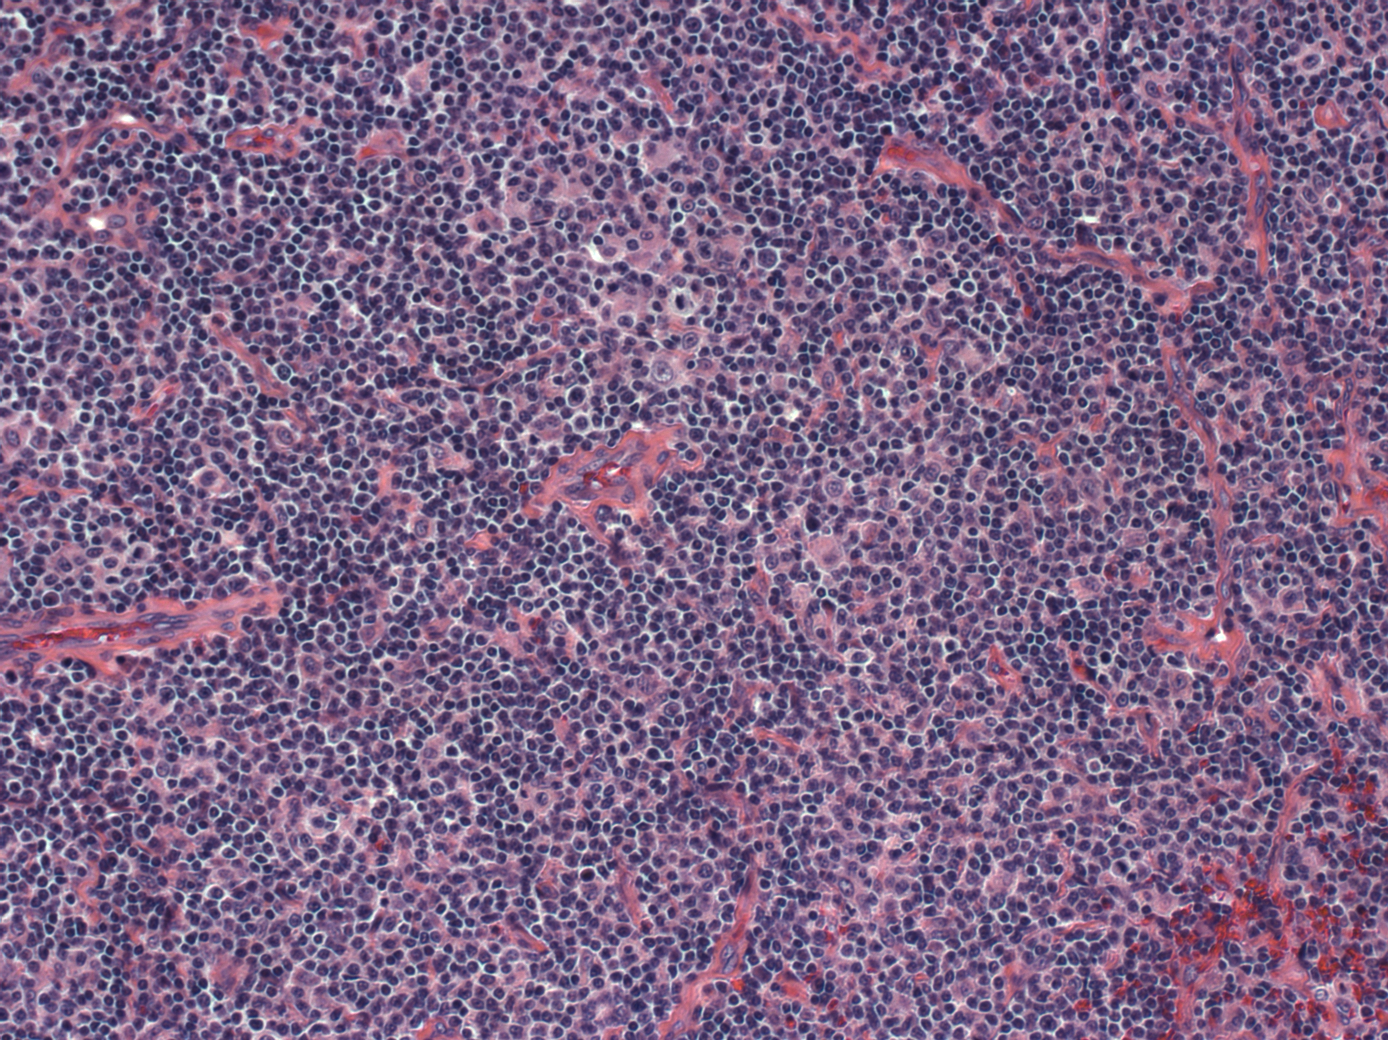

In [8]:
full_image

### Create custom dataset class to handle loading and transforming

Next we'll build a custom dataset class to handle loading and transforming our files from disk to use as input. This allows data to be loaded in batches rather than having to have the entire dataset in memory -- a key feature of SGD.

In [9]:
from torch.utils.data import DataLoader, Dataset

class LymphomaImageDataset(Dataset):
    def __init__(self, path_label_pairs):
        self.img_labels = path_label_pairs

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels[idx][0]
        input_image = Image.open(img_path)
        preprocess = transforms.Compose([
            transforms.Resize(512),
            transforms.CenterCrop(512),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        input_tensor = preprocess(input_image)
        label = self.img_labels[idx][1]
        return input_tensor, label

training_data = LymphomaImageDataset(train_pairs)
test_data = LymphomaImageDataset(test_pairs)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [10]:
len(train_pairs), len(test_pairs), len(img_labels)

(261, 113, 374)

### Display a few image and label pairs.

Feature batch shape: torch.Size([64, 3, 512, 512])
Labels batch shape: torch.Size([64])


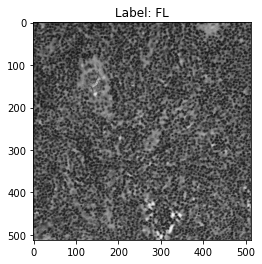

Feature batch shape: torch.Size([64, 3, 512, 512])
Labels batch shape: torch.Size([64])


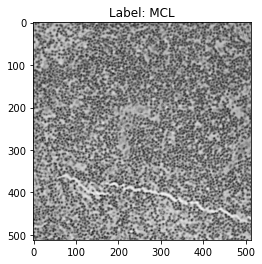

Feature batch shape: torch.Size([64, 3, 512, 512])
Labels batch shape: torch.Size([64])


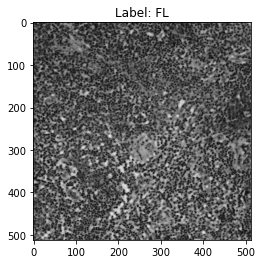

Feature batch shape: torch.Size([64, 3, 512, 512])
Labels batch shape: torch.Size([64])


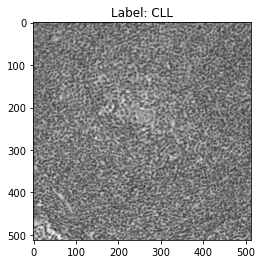

Feature batch shape: torch.Size([64, 3, 512, 512])
Labels batch shape: torch.Size([64])


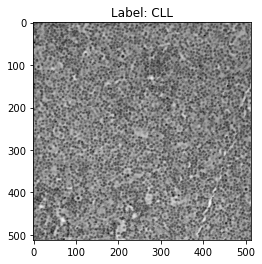

In [11]:
for i in range(5):
    train_features, train_labels = next(iter(train_dataloader))
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")
    img = train_features[0].squeeze()
    label = train_labels[0]
    plt.imshow(img[0], cmap="gray")  # Just the first color channel for simplicity
    plt.title(f"Label: {label_dict[label.item()]}")
    plt.show()

# Transfer Learning from pre-trained ResNet-50

The idea will be to use the pre-trained ResNet model which was trained on imagenet. We'll remove the fully connected output layer and add on our own which we'll use to sub-type the images. Since we have very little data (and no gpu right now :) ), we won't update the weights on the hidden layers but rather only compute gradients and update the wieghts on the output layer. This layer will have input size 2048 and output size 3, to match the number of classes we are modeling.


In [13]:
torch.__version__

'1.7.1'

In [14]:
import torchvision
torchvision.__version__

'0.8.0a0'

In [15]:
class resnet_transfer(nn.Module):
    def __init__(self, num_classes = 3):
        super(resnet_transfer, self).__init__()
        # Load the pre-trained model
        model = torch.hub.load('pytorch/vision:v0.8.0', 'resnet50', pretrained=True)
        # Freeze the parameters of the resnet. We don't want to retrain these
        for param in model.parameters():
            param.requires_grad = False
        num_final_in = model.fc.in_features
        # Overwrite the final layer with a fully connected output 
        # with just 3 classes. 
        model.fc = nn.Linear(num_final_in, num_classes)
        
        self.model = model

    def forward(self, x):
        y = self.model(x)
        return y

model = resnet_transfer()
model.eval()

Downloading: "https://github.com/pytorch/vision/archive/v0.8.0.zip" to /home/chiversc/.cache/torch/hub/v0.8.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/chiversc/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100.0%


resnet_transfer(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

# Model Training

Now we just need to define the training and testing loops, loss function, and optimizer. Pytorch makes this quite simple. In the training loop it's just these steps:
- **run a forward pass** of the input through the model
- **Compute the loss** (we'll use cross-entropy loss for our multiclass setup)
- **Zero out the gradients.** The docs indicate that gradients are always added together so we need to zero them out before we run the backprop.
- **Backpropogate** autodiff FTW! compute the gradients
- **Update** the parameters using the optimizer

In [16]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [17]:
learning_rate = 1e-3
epochs = 20

loss_fn = nn.CrossEntropyLoss()

# Make sure we only compute gradients and update the parameters on the output layer
params_to_learn = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.SGD(params_to_learn, lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)

Epoch 1
-------------------------------
loss: 1.179404  [    0/  261]
Test Error: 
 Accuracy: 23.9%, Avg loss: 1.129858 

Epoch 2
-------------------------------
loss: 1.129563  [    0/  261]


KeyboardInterrupt: 

Approaching 60% accuracy for a 3-class problem. We'd expect ~33% if it were totally random. Here I'm assuming that the images are independant and from unique patients/samples. This might not be true and part of the 'better than random' effect _could_ be due to pseudo-replicates. However, my interest here isn't in getting the best or most robust result but rather to simply take a first pass at applying transfer learning in a digital pathology setting.

# Further Steps
This notebook is intended to demonstrate a very simplified use of a pre-trained model applied to a pathology computer vision task. Several additional steps would be needed in the path to creating a robust, deployable, solution including, but not limited to:

- Preprocessing images for quality control, remove artifacts and color-standardize
- Splitting images into tiles rather than using the entire image as a single input. Tile size could be selected using domain knowledge about the relevent scale of the biological processes. But could also be learned as a hyperparameter.
- Data augmentation to increase sample size and improve generalizability (eg. random rotation, perturbation)
- Evaluation against an independent holdout set, ideally from an independent study site with samples taken from actual workflows (ie non-enriched with an over-representation of pathology of interest)
- Loss curve (learning curve) tracking & plotting
- Adding Dropout/regularization for overfitting
- Model checkpointing during training process
- Hyperparameter optimization
- GPUs! Automated experimentation/ablation studies, etc distributed in cloud (using terraform infra as code).
- Explainable/interpretable modules, user testing
- Evaluation of clinical utility using a decision theoretic framework -- Estimate net benefit as a triage tool, safety net, or other usecase

In [32]:
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(list(model.children())[0].children())

In [33]:
# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 49


In [34]:
# take a look at the conv layers and the respective weights
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) ====> SHAPE: torch.Size([64, 3, 7, 7])
CONV: Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 1, 1])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([256, 64, 1, 1])
CONV: Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 256, 1, 1])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 64, 3, 3])
CONV: Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([256, 64, 1, 1])
CONV: Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False) ====> SHAPE: torch.Size([64, 256, 1, 1])
CONV: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False

In [40]:
for i, mw in enumerate(model_weights):
    print(i, mw.shape)

0 torch.Size([64, 3, 7, 7])
1 torch.Size([64, 64, 1, 1])
2 torch.Size([64, 64, 3, 3])
3 torch.Size([256, 64, 1, 1])
4 torch.Size([64, 256, 1, 1])
5 torch.Size([64, 64, 3, 3])
6 torch.Size([256, 64, 1, 1])
7 torch.Size([64, 256, 1, 1])
8 torch.Size([64, 64, 3, 3])
9 torch.Size([256, 64, 1, 1])
10 torch.Size([128, 256, 1, 1])
11 torch.Size([128, 128, 3, 3])
12 torch.Size([512, 128, 1, 1])
13 torch.Size([128, 512, 1, 1])
14 torch.Size([128, 128, 3, 3])
15 torch.Size([512, 128, 1, 1])
16 torch.Size([128, 512, 1, 1])
17 torch.Size([128, 128, 3, 3])
18 torch.Size([512, 128, 1, 1])
19 torch.Size([128, 512, 1, 1])
20 torch.Size([128, 128, 3, 3])
21 torch.Size([512, 128, 1, 1])
22 torch.Size([256, 512, 1, 1])
23 torch.Size([256, 256, 3, 3])
24 torch.Size([1024, 256, 1, 1])
25 torch.Size([256, 1024, 1, 1])
26 torch.Size([256, 256, 3, 3])
27 torch.Size([1024, 256, 1, 1])
28 torch.Size([256, 1024, 1, 1])
29 torch.Size([256, 256, 3, 3])
30 torch.Size([1024, 256, 1, 1])
31 torch.Size([256, 1024, 1, 

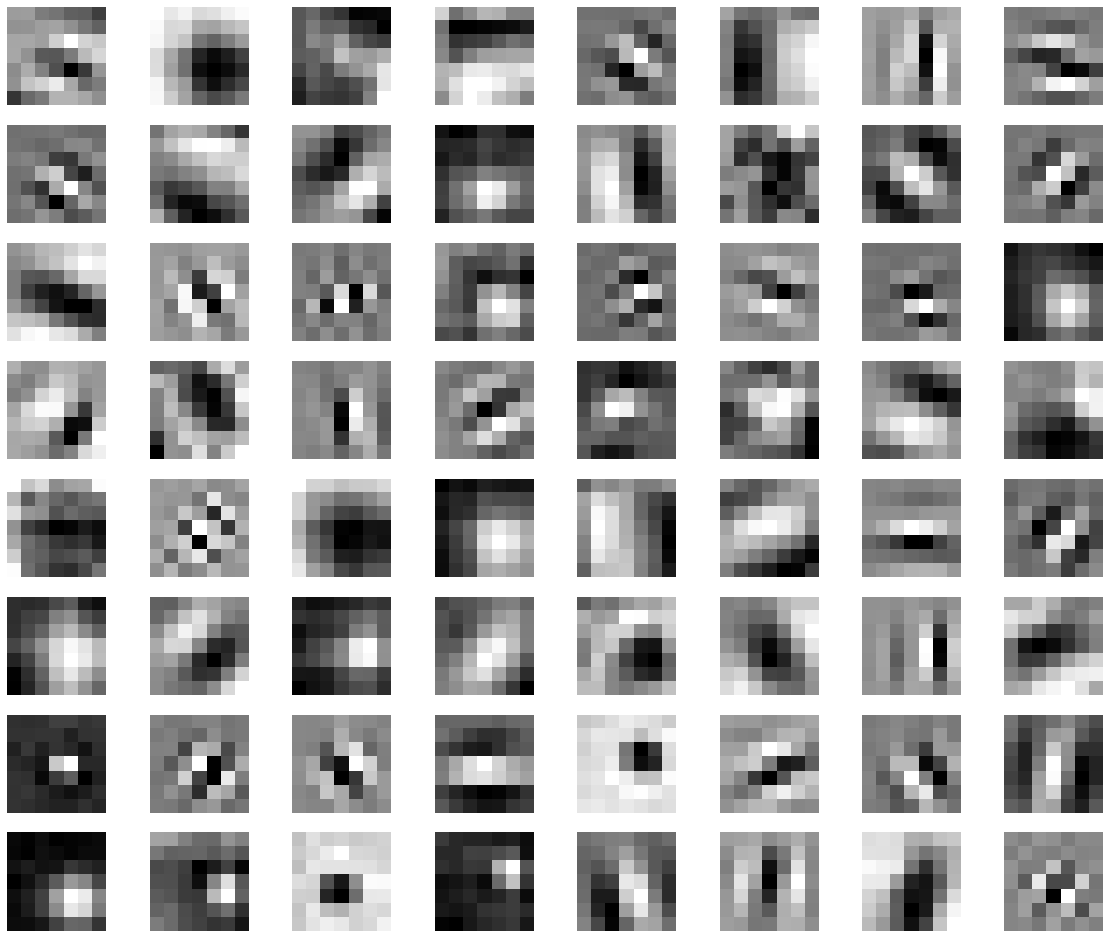

In [48]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
    #plt.savefig('../outputs/filter.png')
plt.show()